# vLLM Scaling Experiment Analysis

## 1. Setup and Data Loading

Load the aggregated experiment results from `summary_metrics.parquet` and prepare the data for analysis.

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Load the aggregated data
try:
    df = pd.read_parquet('../results/agg/summary_metrics.parquet')
    print("Successfully loaded summary_metrics.parquet")
    print(f"Data shape: {df.shape}")
    print("Columns:", df.columns.tolist())
except FileNotFoundError:
    print("Error: summary_metrics.parquet not found. Please run scripts/aggregate_metrics.py first.")

# Set plot style
sns.set_theme(style="whitegrid")

Successfully loaded summary_metrics.parquet
Data shape: (12, 21)
Columns: ['gpu_count', 'request_rate', 'prompt_profile', 'batch_size', 'max_batched_tokens', 'tp', 'dp', 'quant', 'successful_requests', 'benchmark_duration_s', 'total_input_tokens', 'total_generated_tokens', 'request_throughput_req_s', 'output_token_throughput_tok_s', 'total_token_throughput_tok_s', 'mean_ttft_ms', 'median_ttft_ms', 'p99_ttft_ms', 'mean_tpot_ms', 'median_tpot_ms', 'p99_tpot_ms']


## 2. Throughput Analysis

Analyze how throughput scales with the number of GPUs. We will look at both requests/sec and total tokens/sec.

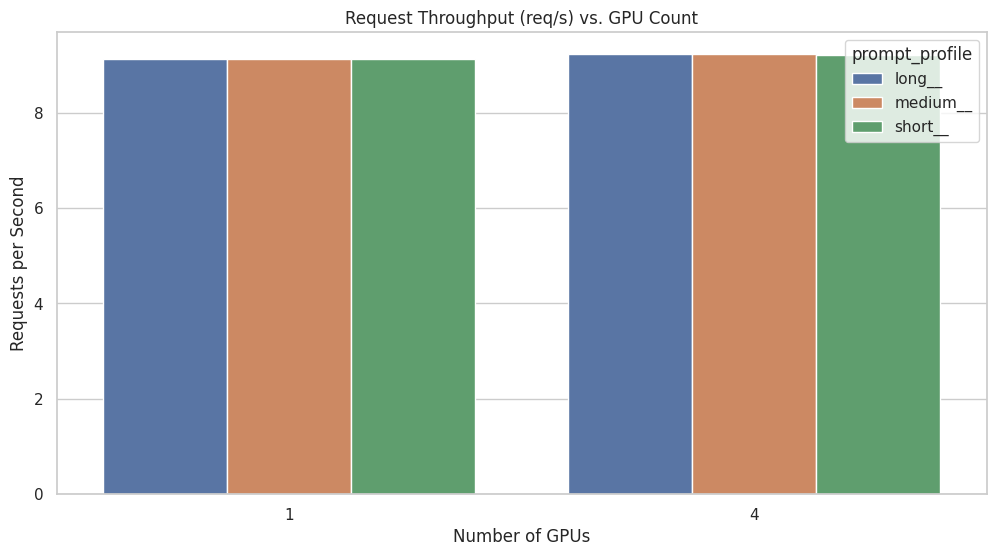

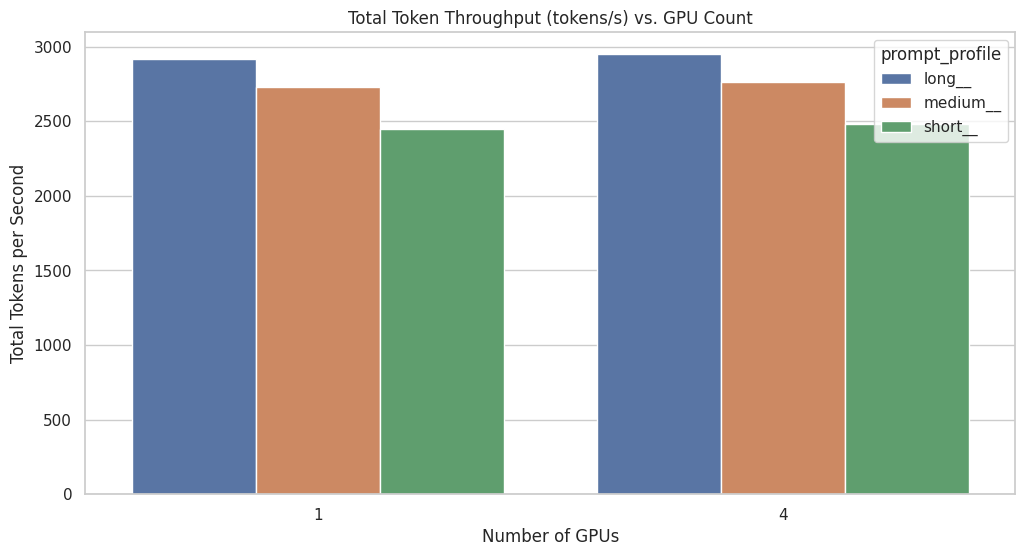

In [20]:
if 'df' in locals():
    # Plot 1: Request Throughput Scaling
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='gpu_count', y='request_throughput_req_s', hue='prompt_profile', errorbar=None)
    plt.title('Request Throughput (req/s) vs. GPU Count')
    plt.xlabel('Number of GPUs')
    plt.ylabel('Requests per Second')
    plt.savefig('../results/figs/throughput_scaling_req_s.png')
    plt.show()

    # Plot 2: Total Token Throughput Scaling
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='gpu_count', y='total_token_throughput_tok_s', hue='prompt_profile', errorbar=None)
    plt.title('Total Token Throughput (tokens/s) vs. GPU Count')
    plt.xlabel('Number of GPUs')
    plt.ylabel('Total Tokens per Second')
    plt.savefig('../results/figs/throughput_scaling_tok_s.png')
    plt.show()

## 3. Latency Analysis

Analyze different latency metrics (TTFT, TPOT) across different configurations.

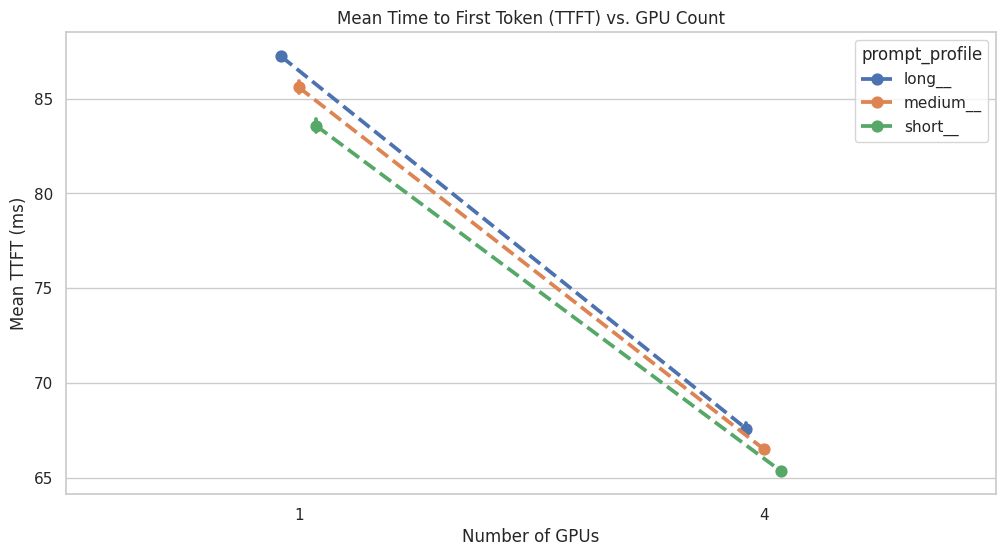

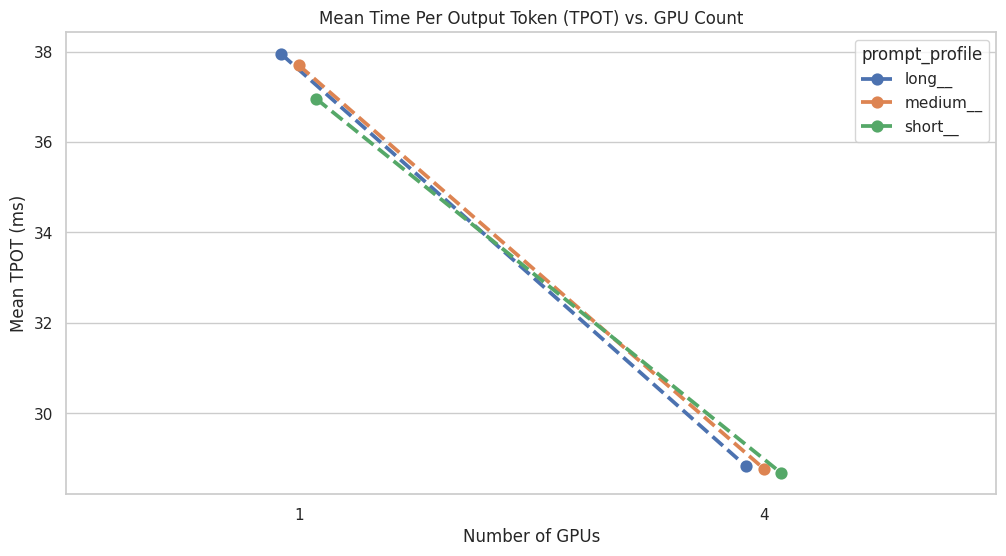

In [21]:
if 'df' in locals():
    # Plot 3: Mean Time to First Token (TTFT)
    plt.figure(figsize=(12, 6))
    sns.pointplot(data=df, x='gpu_count', y='mean_ttft_ms', hue='prompt_profile', dodge=True, linestyles='--')
    plt.title('Mean Time to First Token (TTFT) vs. GPU Count')
    plt.xlabel('Number of GPUs')
    plt.ylabel('Mean TTFT (ms)')
    plt.savefig('../results/figs/latency_ttft.png')
    plt.show()

    # Plot 4: Mean Time Per Output Token (TPOT)
    plt.figure(figsize=(12, 6))
    sns.pointplot(data=df, x='gpu_count', y='mean_tpot_ms', hue='prompt_profile', dodge=True, linestyles='--')
    plt.title('Mean Time Per Output Token (TPOT) vs. GPU Count')
    plt.xlabel('Number of GPUs')
    plt.ylabel('Mean TPOT (ms)')
    plt.savefig('../results/figs/latency_tpot.png')
    plt.show()

## 4. Throughput vs. Latency Trade-off

Visualize the relationship between throughput and latency to understand the performance trade-offs.

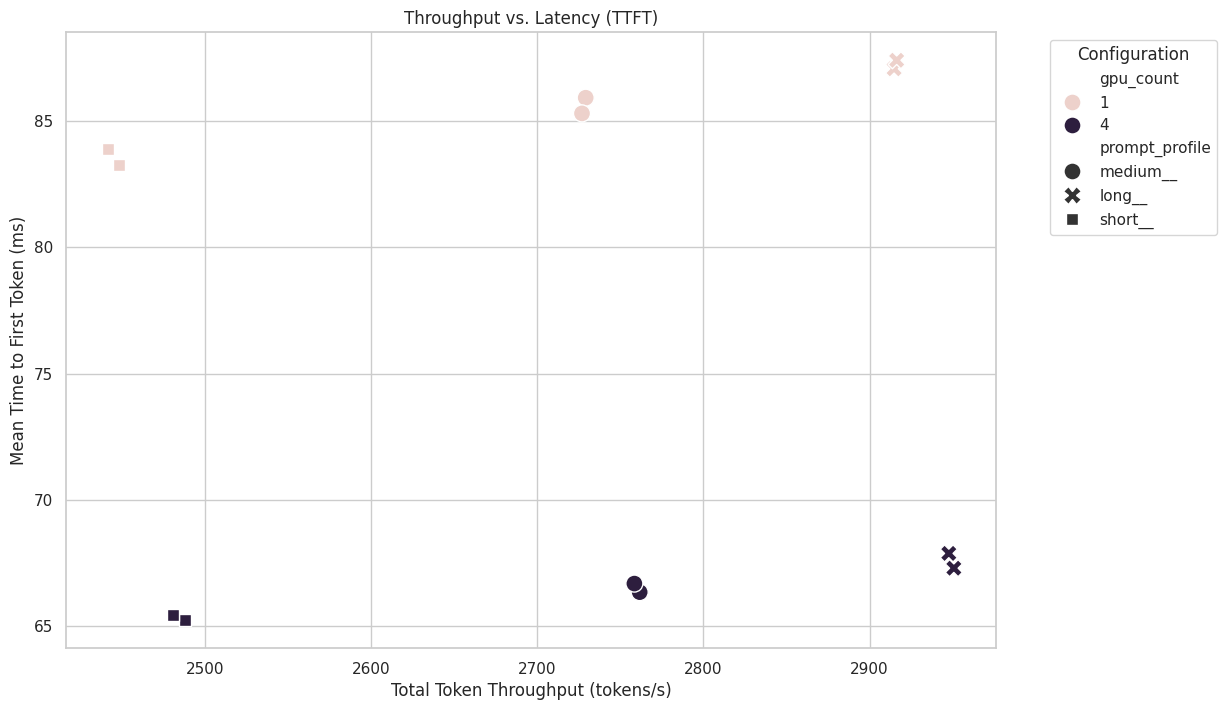

In [22]:
if 'df' in locals():
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='total_token_throughput_tok_s', y='mean_ttft_ms', hue='gpu_count', style='prompt_profile', s=150)
    plt.title('Throughput vs. Latency (TTFT)')
    plt.xlabel('Total Token Throughput (tokens/s)')
    plt.ylabel('Mean Time to First Token (ms)')
    plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.savefig('../results/figs/tradeoff_throughput_vs_latency.png')
    plt.show()

## 5. Amdahl's Law Analysis

Load the `amdahl_fit.csv` data to see the calculated speedup and the estimated sequential portion (`s`) of the workload.

In [23]:
try:
    amdahl_df = pd.read_csv('../results/agg/amdahl_fit.csv')
    print("Amdahl's Law Analysis Results:")
    display(amdahl_df)
except FileNotFoundError:
    print("amdahl_fit.csv not found. Please run scripts/amdahl_fit.py first.")

Amdahl's Law Analysis Results:


,gpu_count,speedup,estimated_s
0,4,1.01296,0.982941


## 6. Summary Table

Display a summary table of key performance indicators (KPIs) grouped by the main experiment factors.

In [24]:
if 'df' in locals():
    summary_table = df.groupby(['gpu_count', 'prompt_profile', 'batch_size']).agg(
        avg_req_throughput=('request_throughput_req_s', 'mean'),
        avg_token_throughput=('total_token_throughput_tok_s', 'mean'),
        avg_ttft_ms=('mean_ttft_ms', 'mean'),
        avg_tpot_ms=('mean_tpot_ms', 'mean')
    ).reset_index()

    # Format the table for better readability
    summary_table = summary_table.round(2)

    print("Experiment Summary Table:")
    display(summary_table)


Experiment Summary Table:


,gpu_count,prompt_profile,batch_size,avg_req_throughput,avg_token_throughput,avg_ttft_ms,avg_tpot_ms
0,1,long__,16,9.12,2916.33,87.40,37.96
1,1,long__,32,9.12,2914.76,87.06,37.93
2,1,medium__,16,9.12,2729.23,85.92,37.71
3,1,medium__,32,9.11,2727.00,85.30,37.69
4,1,short__,16,9.13,2442.08,83.91,36.99
5,1,short__,32,9.13,2448.62,83.25,36.93
6,4,long__,16,9.23,2950.72,67.29,28.78
7,4,long__,32,9.22,2947.69,67.88,28.88
8,4,medium__,16,9.22,2758.52,66.68,28.82
9,4,medium__,32,9.23,2761.71,66.34,28.74


## 7. Analysis of Batch Size Impact

This section analyzes the impact of `batch_size` on performance. Given the low request rate (10 req/s), we expect the impact to be minimal, as the system is not saturated enough to benefit from larger batch processing.

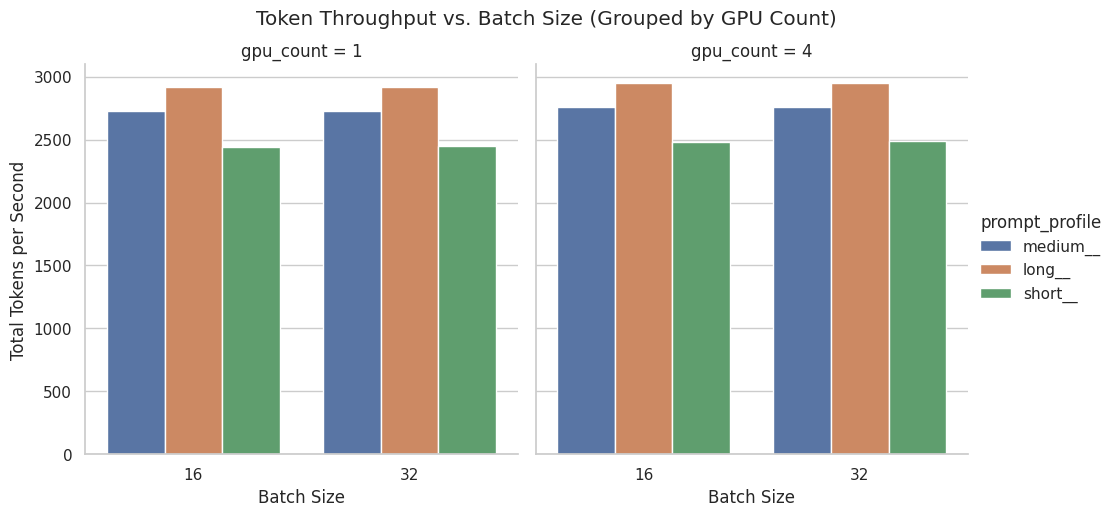

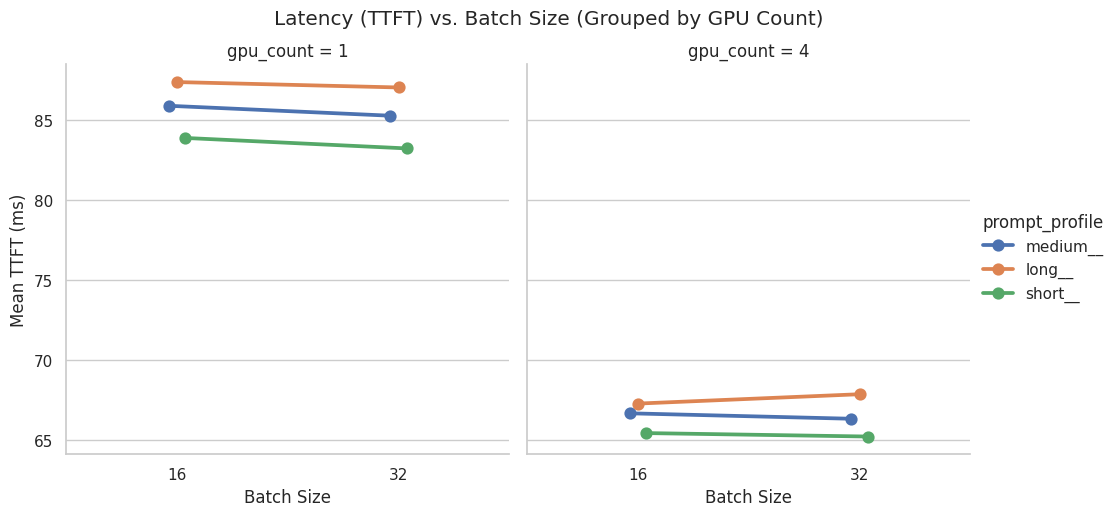

In [25]:
if 'df' in locals():
    # Plot 5: Token Throughput by Batch Size
    g = sns.catplot(data=df, x='batch_size', y='total_token_throughput_tok_s', \
                    col='gpu_count', hue='prompt_profile', kind='bar', errorbar=None)
    g.fig.suptitle('Token Throughput vs. Batch Size (Grouped by GPU Count)', y=1.03)
    g.set_axis_labels('Batch Size', 'Total Tokens per Second')
    plt.savefig('../results/figs/impact_batch_size_throughput.png')
    plt.show()

    # Plot 6: Latency (TTFT) by Batch Size
    g = sns.catplot(data=df, x='batch_size', y='mean_ttft_ms', \
                    col='gpu_count', hue='prompt_profile', kind='point', dodge=True)
    g.fig.suptitle('Latency (TTFT) vs. Batch Size (Grouped by GPU Count)', y=1.03)
    g.set_axis_labels('Batch Size', 'Mean TTFT (ms)')
    plt.savefig('../results/figs/impact_batch_size_latency.png')
    plt.show()


### Interpretation:

As hypothesized, the graphs above show that changing the `batch_size` from 16 to 32 has a negligible effect on both token throughput and latency. 

- **Throughput:** The bar charts are nearly flat, indicating that a larger batch size did not allow the system to process significantly more tokens per second.
- **Latency:** The point plots also show very little change. A slight, almost insignificant decrease in TTFT can be observed, but it's not a meaningful improvement.

This confirms that the true bottleneck in this experiment is the low `request_rate`, which prevents the vLLM engine from accumulating enough pending requests to take advantage of larger batch sizes.